In [1]:
!pip install -q efficientnet

In [2]:
# load required packages

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
import plotly.express as px


import os
import random
import re
import math
import time

from tqdm import tqdm
from tqdm.keras import TqdmCallback


from pandas_summary import DataFrameSummary

import warnings


warnings.filterwarnings('ignore') # Disabling warnings for clearer outputs

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)


import numpy as np
import pandas as pd
import os
import random, re, math, time
random.seed(a=128)

from os.path import join 

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn

from tqdm.keras import TqdmCallback

from PIL import Image
import PIL

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from pandas_summary import DataFrameSummary

from kaggle_datasets import KaggleDatasets

from tqdm import tqdm

In [3]:
# Set colors
orange_black = [
    '#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820'
]

In [4]:
print(os.listdir("../input"))

['melanoma-384x384', 'melanoma-128x128', 'image-names', 'siim-isic-melanoma-classification', 'melanoma2020imgtabular']


In [5]:
# Setting file paths

base_path = '/kaggle/input/siim-isic-melanoma-classification'
train_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
img_stats_path = '/kaggle/input/melanoma2020imgtabular'

# Loading the Data

Train data has 8 features, 33126 observations



In [6]:
# Loading train and test data.

train = pd.read_csv(os.path.join(base_path, 'train.csv'))
test = pd.read_csv(os.path.join(base_path, 'test.csv'))
sample = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))

In [7]:
# Checking train and test columns/rows.

print(
    f'Train data has {train.shape[1]} features, {train.shape[0]} observations and Test data {test.shape[1]} features, {test.shape[0]} observations.\nTrain features are:\n{train.columns.tolist()}\nTest features are:\n{test.columns.tolist()}'
)

Train data has 8 features, 33126 observations and Test data 5 features, 10982 observations.
Train features are:
['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant', 'target']
Test features are:
['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge']


In [8]:
# Renaming train/test columns:

train.columns = [
    'img_name', 'id', 'sex', 'age', 'location', 'diagnosis',
    'benign_malignant', 'target'
]
test.columns = ['img_name', 'id', 'sex', 'age', 'location']

# Missing Data

In [9]:
# Filling missing values with 'unknown' tag:

for df in [train, test]:
    df['location'].fillna('unknown', inplace=True)

In [10]:
# checks

ids_train = train.location.values
ids_test = test.location.values
ids_train_set = set(ids_train)
ids_test_set = set(ids_test)

location_not_overlap = list(ids_train_set.symmetric_difference(ids_test_set))
n_overlap = len(location_not_overlap)
if n_overlap == 0:
    print(
        f'Same data in both'
    )
else:
    print('Not same data in both')

Same data in both


In [11]:


train['sex'].fillna(train['sex'].mode()[0], inplace=True)

train['age'].fillna(train['age'].median(), inplace=True)

In [12]:
# Checking missing value counts:

print(
    f'Train missing value count: {train.isnull().sum().sum()}\nTest missing value count: {train.isnull().sum().sum()}'
)

Train missing value count: 0
Test missing value count: 0


In [13]:
train['age_min'] = train['id'].map(train.groupby(['id']).age.min())
train['age_max'] = train['id'].map(train.groupby(['id']).age.max())

test['age_min'] = test['id'].map(test.groupby(['id']).age.min())
test['age_max'] = test['id'].map(test.groupby(['id']).age.max())

In [14]:
train['n_images'] = train.id.map(train.groupby(['id']).img_name.count())
test['n_images'] = test.id.map(test.groupby(['id']).img_name.count())

# Loading Image Meta Features



In [15]:
# Get image sizes:

for data, location in zip([train, test], [train_img_path, test_img_path]):
    images = data['img_name'].values
    sizes = np.zeros(images.shape[0])
    for i, path in enumerate(tqdm(images)):
        sizes[i] = os.path.getsize(os.path.join(location, f'{path}.jpg'))

    data['image_size'] = sizes

100%|██████████| 10982/10982 [00:39<00:00, 281.48it/s]


# Image Sizes



In [16]:
# Loading color data:

train_attr = pd.read_csv(
    os.path.join(img_stats_path, 'train_mean_colorres.csv'))
test_attr = pd.read_csv(os.path.join(img_stats_path, 'test_mean_colorres.csv'))

In [17]:
train_attr.head()

,reds,greens,blues,mean_colors,width,height,total_pixels
0,212.935898,138.914175,157.742255,169.864109,6000,4000,24000000
1,217.292550,165.093667,130.881285,171.089167,6000,4000,24000000
2,199.941121,130.227057,145.908743,158.692307,1872,1053,1971216
3,119.690968,62.614725,58.724976,80.343556,1872,1053,1971216
4,226.279244,173.174914,152.425131,183.959763,6000,4000,24000000


In [18]:
train = pd.concat([train, train_attr], axis=1)
test = pd.concat([test, test_attr], axis=1)

train['res'] = train['width'].astype(str) + 'x' + train['height'].astype(str)
test['res'] = test['width'].astype(str) + 'x' + test['height'].astype(str)

# Meta data section

## Landscape features

In [19]:
# load image names and rename column to match train
image_names_df = pd.read_csv('../input/image-names/Image_Names.csv')
image_names_df.columns = ['img_name']


In [20]:
# Loading lanscape data

train40 = pd.read_csv('../input/melanoma2020imgtabular/train40Features.csv')
test40 = pd.read_csv('../input/melanoma2020imgtabular/test40Features.csv')

trainmet = pd.read_csv('../input/melanoma2020imgtabular/trainMetrics.csv')
testmet = pd.read_csv('../input/melanoma2020imgtabular/testMetrics.csv')

In [21]:

train40.columns

Index(['sex', 'age_approx', 'anatom_site_general_challenge', 'V1', 'V2', 'V3',
       'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24',
       'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34',
       'V35', 'V36', 'V37'],
      dtype='object')

In [22]:
# Dropping duplicate data from lanscape dataset

train40.drop(['sex', 'age_approx', 'anatom_site_general_challenge'],
             axis=1,
             inplace=True)

test40.drop(['sex', 'age_approx', 'anatom_site_general_challenge'],
            axis=1,
            inplace=True)

In [23]:
# adding landscape metric names to train and test data
train40.columns = ['total_area','number_of_patches','patch_density','largest_patch_index','total_edge','edge_density','landscape_shape_index','effective_mesh_size','area_mn','area_am','area_md','area_ra','area_sd','area_cv','perimeter_mn','perimeter_am','perimeter_md','perimeter_ra','perimeter_sd','perimeter_cv','perimeter_area_ratio_mn','perimeter_area_ratio_am','perimeter_area_ratio_md','perimeter_area_ratio_ra','perimeter_area_ratio_sd','perimeter_area_ratio_cv','shape_index_mn','shape_index_am','shape_index_md','shape_index_ra','shape_index_sd','shape_index_cv','fractal_dimension_mn','fractal_dimension_ra','fractal_dimension_sd','contagion','shannon_diversity_index']
test40.columns = ['total_area','number_of_patches','patch_density','largest_patch_index','total_edge','edge_density','landscape_shape_index','effective_mesh_size','area_mn','area_am','area_md','area_ra','area_sd','area_cv','perimeter_mn','perimeter_am','perimeter_md','perimeter_ra','perimeter_sd','perimeter_cv','perimeter_area_ratio_mn','perimeter_area_ratio_am','perimeter_area_ratio_md','perimeter_area_ratio_ra','perimeter_area_ratio_sd','perimeter_area_ratio_cv','shape_index_mn','shape_index_am','shape_index_md','shape_index_ra','shape_index_sd','shape_index_cv','fractal_dimension_mn','fractal_dimension_ra','fractal_dimension_sd','contagion','shannon_diversity_index',]

In [24]:
# add images names to train40
train40 = pd.concat([image_names_df, train40], axis=1)

In [25]:
# merging both datasets

train = pd.merge(train, train40, on='img_name')
test = pd.concat([test, test40], axis=1)

In [26]:
train.columns

Index(['img_name', 'id', 'sex', 'age', 'location', 'diagnosis',
       'benign_malignant', 'target', 'age_min', 'age_max', 'n_images',
       'image_size', 'reds', 'greens', 'blues', 'mean_colors', 'width',
       'height', 'total_pixels', 'res', 'total_area', 'number_of_patches',
       'patch_density', 'largest_patch_index', 'total_edge', 'edge_density',
       'landscape_shape_index', 'effective_mesh_size', 'area_mn', 'area_am',
       'area_md', 'area_ra', 'area_sd', 'area_cv', 'perimeter_mn',
       'perimeter_am', 'perimeter_md', 'perimeter_ra', 'perimeter_sd',
       'perimeter_cv', 'perimeter_area_ratio_mn', 'perimeter_area_ratio_am',
       'perimeter_area_ratio_md', 'perimeter_area_ratio_ra',
       'perimeter_area_ratio_sd', 'perimeter_area_ratio_cv', 'shape_index_mn',
       'shape_index_am', 'shape_index_md', 'shape_index_ra', 'shape_index_sd',
       'shape_index_cv', 'fractal_dimension_mn', 'fractal_dimension_ra',
       'fractal_dimension_sd', 'contagion', 'shannon_dive

In [27]:
#GET NUMBER OF THE TFREC FOLDER to match with csv
def tf_data_items(filenames):    
    n = [(re.compile(r"n([0-9][0-9]*)\-").search(filename).group(1)) for filename in filenames]
    return n

In [28]:
GCS_PATH = KaggleDatasets().get_gcs_path('melanoma-384x384')
TRAINING_FILENAMES, TEST_FILENAMES =  np.array(train_test_split(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec'), test_size=0.1, random_state=42))
TRAINING_FILENAMES, VALIDATION_FILENAMES =  np.array(train_test_split(TRAINING_FILENAMES, test_size=0.2, random_state=42))


In [29]:
# files in each tf record
# this is being done to prevent data leakage between the cnn and the XGB. both models should see the same data
xs_train = (tf_data_items(TRAINING_FILENAMES))
xs_train = [int(i) for i in xs_train]
xs_test = (tf_data_items(TEST_FILENAMES))
xs_test = [int(i) for i in xs_test]
xs_valid = (tf_data_items(VALIDATION_FILENAMES))
xs_valid = [int(i) for i in xs_valid]
print(xs_train)
print(xs_test)
print(xs_valid)

[7, 1, 5, 13, 6, 2, 4, 12, 8, 14]
[9, 11]
[3, 10, 0]


In [30]:
train_tfrec_data = pd.read_csv(os.path.join(GCS_PATH + '/train.csv'))

In [31]:
# getting images in each tfrec, same as used in CNN
tf_fn = train_tfrec_data[train_tfrec_data['tfrecord'].isin(xs_train)]
tf_fn = tf_fn['image_name']
tf_fn_test = train_tfrec_data[train_tfrec_data['tfrecord'].isin(xs_test)]
tf_fn_test = tf_fn_test['image_name']
tf_fn_valid = train_tfrec_data[train_tfrec_data['tfrecord'].isin(xs_valid)]
tf_fn_valid = tf_fn_valid['image_name']

In [32]:
print(tf_fn.nunique())
print(tf_fn_test.nunique())
print(tf_fn_valid.nunique())

21800
4354
6538


In [33]:
train_n = train[train['img_name'].isin(tf_fn)]
test_n = train[train['img_name'].isin(tf_fn_test)]
valid_n =  train[train['img_name'].isin(tf_fn_valid)]

In [34]:
test_n.head()
testy = test_n[['img_name','target']]
testy.head()

,img_name,target
4,ISIC_0074268,0
7,ISIC_0075663,0
9,ISIC_0076262,0
11,ISIC_0076742,0
23,ISIC_0082543,0


In [35]:
test_image_names = test_n['img_name']

# Creating dummy variables

In [36]:
# dummy variables for gender on train set

sex_dummies = pd.get_dummies(train_n['sex'], prefix='sex')
train_n = pd.concat([train_n, sex_dummies], axis=1)

# test set

sex_dummies = pd.get_dummies(test_n['sex'], prefix='sex')
test_n = pd.concat([test_n, sex_dummies], axis=1)

# valid set

sex_dummies = pd.get_dummies(valid_n['sex'], prefix='sex')
valid_n = pd.concat([valid_n, sex_dummies], axis=1)

# drop cols

train_n.drop(['sex','res','img_name','id','diagnosis','benign_malignant'], axis=1, inplace=True)
test_n.drop(['sex','res','img_name','id','target','diagnosis','benign_malignant'], axis=1, inplace=True)
valid_n.drop(['sex','res','img_name','id','diagnosis','benign_malignant'], axis=1, inplace=True)

In [37]:
# dummy variables for location on train set

anatom_dummies = pd.get_dummies(train_n['location'], prefix='anatom')
train_n = pd.concat([train_n, anatom_dummies], axis=1)

# test set

anatom_dummies = pd.get_dummies(test_n['location'], prefix='anatom')
test_n = pd.concat([test_n, anatom_dummies], axis=1)

# valid set

anatom_dummies = pd.get_dummies(valid_n['location'], prefix='anatom')
valid_n = pd.concat([valid_n, anatom_dummies], axis=1)

# drop cols

train_n.drop('location', axis=1, inplace=True)
test_n.drop('location', axis=1, inplace=True)
valid_n.drop('location', axis=1, inplace=True)

# XGBoost

In [38]:
# loading libraries
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve

In [39]:
# split train set and labels

X = train_n.drop('target', axis=1)
y = train_n.target

X_v = valid_n.drop('target', axis=1)
y_v = valid_n.target

In [40]:
import imblearn
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.1)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1)

In [41]:
# steps = [ ('u', under)]
steps = [('o', over), ('u', under)]
pipeline = imblearn.pipeline.Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)

In [42]:
y.value_counts()

0    2141
1    2141
Name: target, dtype: int64

## Model Training XGB



In [43]:
#stratify for cv
cv = KFold(5, shuffle=True, random_state=42)

scale_pos_weight = majority / minority

In [44]:
weight = y.value_counts()[0]/ y.value_counts()[1]
weight

1.0

In [45]:
#setting model hyperparameters

xg = XGBClassifier(
    n_estimators=750,
    min_child_weight=0.81,
    learning_rate=0.025,
    max_depth=2,
    subsample=0.80,
    colsample_bytree=0.42,
    gamma=0.10,
    random_state=42,    
    #n_jobs=-1,
    scale_pos_weight = weight
)

estimators = [xg]

In [46]:
# fitting train data
evals_result ={}
eval_s = [(X, y),(X_v,y_v)]

xg.fit(X, y, eval_set=eval_s)

# predicting on holdout set
validation = xg.predict_proba(X_v)[:, 1]
r = xg.evals_result()
# checking results on validation set
# roc_auc_score(y_v, validation)

[00:09:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.68468	validation_1-logloss:0.68530
[1]	validation_0-logloss:0.67723	validation_1-logloss:0.67859
[2]	validation_0-logloss:0.66968	validation_1-logloss:0.67106
[3]	validation_0-logloss:0.66189	validation_1-logloss:0.66449
[4]	validation_0-logloss:0.65512	validation_1-logloss:0.65768
[5]	validation_0-logloss:0.64856	validation_1-logloss:0.65109
[6]	validation_0-logloss:0.64175	validation_1-logloss:0.64512
[7]	validation_0-logloss:0.63507	validation_1-logloss:0.63930
[8]	validation_0-logloss:0.62952	validation_1-logloss:0.63419
[9]	validation_0-logloss:0.62404	validation_1-logloss:0.62978
[10]	validation_0-logloss:0.61792	validation_1-logloss:0.62477
[11]	validation_0-logloss:0.61303	validation_1-logloss:0.62046
[1

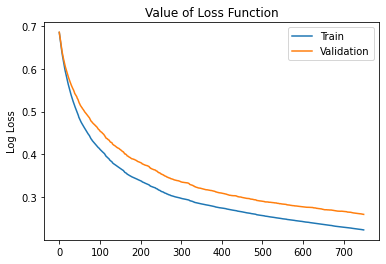

In [47]:
# plot training and validation loss
import matplotlib.pyplot as pyplot
fig, ax = pyplot.subplots()
ax.plot(r['validation_0']['logloss'], label='Train')
ax.plot(r['validation_1']['logloss'], label='Validation')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('Value of Loss Function')
pyplot.show()

# Feature Importances



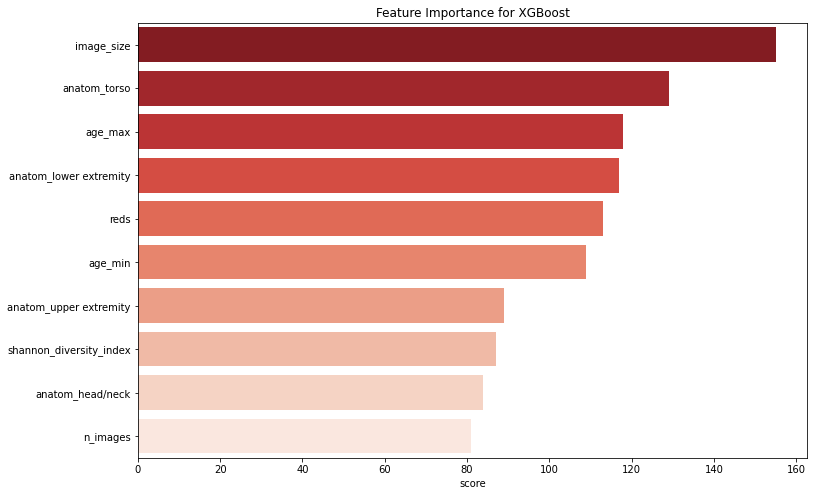

In [48]:
# feature importance

feature_importance = xg.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=importance.score.iloc[:10],
            y=importance.index[:10],
            orient='h',
            palette='Reds_r')
ax.set_title('Feature Importance for XGBoost')
plt.show()

Best Threshold=0.356849, G-Mean=0.773


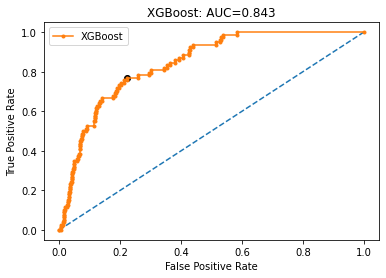

In [49]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import roc_curve, roc_auc_score
from numpy import argmax
from numpy import sqrt
from numpy import arange
from sklearn.metrics import f1_score

# predicting on test set
predictions = xg.predict_proba(test_n)[:, 1]

precision, recall, thresholds = precision_recall_curve(testy['target'], predictions)
fpr, tpr, thresholds = roc_curve(testy['target'], predictions)
ns_auc = roc_auc_score(testy['target'], predictions)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--')#, label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='XGBoost')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black')#, label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.title('XGBoost: AUC=%.3f' % (ns_auc))
# show the plot
pyplot.show()

----- XGBoost -----
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      4276
           1       0.06      0.77      0.11        78

    accuracy                           0.78      4354
   macro avg       0.53      0.77      0.49      4354
weighted avg       0.98      0.78      0.86      4354



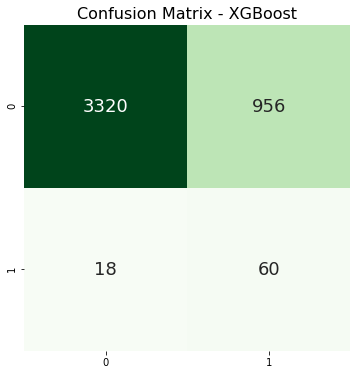

In [50]:
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix, auc, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
print("----- XGBoost -----")
fpr, tpr, _ = roc_curve(testy['target'], predictions)
roc_auc = auc(fpr, tpr)

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report

predictionsXGB = np.where(predictions >= thresholds[ix], 1, 0)
confusion = confusion_matrix(testy['target'],predictionsXGB )
plt.figure(figsize=(6,6))
sns.heatmap(confusion, cbar=False, annot=True, fmt="g", annot_kws={'size':18}, square=True, cmap="Greens")
plt.title('Confusion Matrix - XGBoost', size=16)

print(classification_report(testy['target'], predictionsXGB))


In [51]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(y_true, y_pred):
    transdict = {1: "malignant", 0: "benign"}
    y_t = np.array([transdict[x] for x in y_true])
    y_p = np.array([transdict[x] for x in y_pred])
    
    labels = ["benign", "malignant"]
    index_labels = ["actual benign", "actual malignant"]
    col_labels = ["predicted benign", "predicted malignant"]
    confusion = confusion_matrix(y_t, y_p, labels=labels)
    confusion_df = pd.DataFrame(confusion, index=index_labels, columns=col_labels)
    for n in range(2):
        confusion_df.iloc[n] = confusion_df.iloc[n] / confusion_df.sum(axis=1).iloc[n]
    return confusion_df

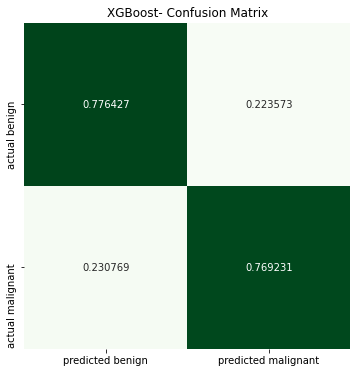

In [52]:
confusion = get_confusion_matrix(testy['target'],predictionsXGB)
plt.figure(figsize=(6,6))
plt.title('XGBoost- Confusion Matrix')
sns.heatmap(confusion, cbar=False, annot=True, fmt="g", square=True, cmap="Greens");

In [53]:
# creating submission df
meta_df_7 = pd.DataFrame(columns=['image_name', 'target'])
# assigning predictions on submission df
meta_df_7['image_name'] = test_image_names
meta_df_7['target'] = predictions


# EfficientNet

In [54]:
DEVICE = "TPU"
BASEPATH = "../input/siim-isic-melanoma-classification"

In [55]:
# Setting TPU 

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE


connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS:  8


In [56]:

EPOCHS = 20
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMAGE_SIZE = [128, 128]

In [57]:
GCS_PATH = KaggleDatasets().get_gcs_path('melanoma-128x128')
TRAINING_FILENAMES, TEST_FILENAMES =  np.array(train_test_split(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec'), test_size=0.1, random_state=42))
TRAINING_FILENAMES, VALIDATION_FILENAMES =  np.array(train_test_split(TRAINING_FILENAMES, test_size=0.2, random_state=42))


In [58]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) 
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        #"class": tf.io.FixedLenFeature([], tf.int64)
        "target": tf.io.FixedLenFeature([], tf.int64),  
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])    
   
    label = tf.cast(example['target'], tf.float32)
    print(example['target'])
    print("label", label)
    return image, label 

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "image_name": tf.io.FixedLenFeature([], tf.string), 
        
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum 

def load_dataset(filenames, labeled=True, ordered=False):
   
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order) 
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    return image, label   

def get_training_dataset():
    print(TRAINING_FILENAMES)
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True, ordered=True)
    print("after load", dataset)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() 
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def get_validation_dataset(ordered=True):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) 
    return dataset

def get_test_dataset(labeled=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=labeled, ordered=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def count_data_items(filenames):
    
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_TEST_IMAGES))

Dataset: 21800 training images, 4354 unlabeled test images


In [59]:
print("Training Files", count_data_items(TRAINING_FILENAMES))
print("Validation Files", count_data_items(VALIDATION_FILENAMES))
print("Testing Files", count_data_items(TEST_FILENAMES))

Training Files 21800
Validation Files 6538
Testing Files 4354


In [60]:
raw_dataset = get_training_dataset()
image_batch, label_batch = next(iter(raw_dataset))

['gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train07-2174.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train01-2185.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train05-2171.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train13-2186.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train06-2175.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train02-2193.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train04-2167.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train12-2198.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train08-2177.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train14-2174.tfrec']
Tensor("ParseSingleExample/ParseExample/ParseExampleV2:1", shape=(), dtype=int64)
label Tensor("Cast_1:0", shape=(), dt

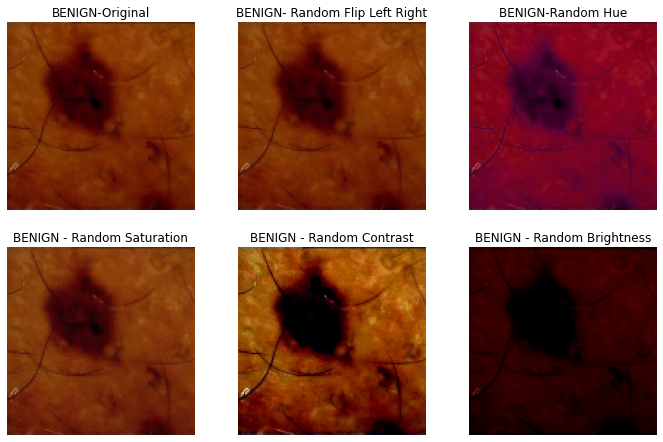

In [61]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20, 20))
    for n in range(1):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("MALIGNANT-Original")
        else:
            plt.title("BENIGN-Original")
        plt.axis("off")
        
        ax = plt.subplot(5, 5, n + 2)
        plt.imshow(tf.image.random_flip_left_right(image_batch[n]))
        if label_batch[n]:
            plt.title("MALIGNANT-Random Flip Left Right")
        else:
            plt.title("BENIGN- Random Flip Left Right")
        plt.axis("off")
        
        ax = plt.subplot(5, 5, n + 3)
        plt.imshow(tf.image.random_hue(image_batch[n], 0.2))
        if label_batch[n]:
            plt.title("MALIGNANT-Random Hue")
        else:
            plt.title("BENIGN-Random Hue")
        plt.axis("off")
        
        ax = plt.subplot(5, 5, n +6)
        plt.imshow(tf.image.random_saturation(image_batch[n], 0.1, 1.3))
        if label_batch[n]:
            plt.title("MALIGNANT- Random Saturation")
        else:
            plt.title("BENIGN - Random Saturation")
        plt.axis("off")
        
        ax = plt.subplot(5, 5, n +7)
        plt.imshow(tf.image.random_contrast(image_batch[n], 0, 5))
        if label_batch[n]:
            plt.title("MALIGNANT- Random Contrast")
        else:
            plt.title("BENIGN - Random Contrast")
        plt.axis("off")
        
        ax = plt.subplot(5, 5, n +8)
        plt.imshow(tf.image.random_brightness(image_batch[n], 0.4))
        if label_batch[n]:
            plt.title("MALIGNANT- Random Brightness")
        else:
            plt.title("BENIGN - Random Brightness")
        plt.axis("off")

show_batch(image_batch, label_batch)

In [62]:
def lrfn(epoch):
    LR_START          = 0.000005
    LR_MAX            = 0.000020 * strategy.num_replicas_in_sync
    LR_MIN            = 0.000001
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .8
    
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

In [63]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.regularizers import l2
#reg_l2 = 0.001

In [64]:
# image size:
tfrec_shape = 128

# select comp data
comp_data = "2020"

# model weights
model_weights = 'imagenet'

In [65]:
# BUILD MODEL

def get_model(model):
    
    model_input = tf.keras.Input(shape=(*IMAGE_SIZE, 3), name='imgIn')
    dummy = tf.keras.layers.Lambda(lambda x:x)(model_input)
    outputs = []

    constructor = getattr(efn, model)
    x = constructor(include_top=False, weights=model_weights, input_shape=(*IMAGE_SIZE, 3), pooling='avg')(dummy)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    outputs.append(x)
    
    model = tf.keras.Model(model_input, outputs, name='aNetwork')
    model.summary()
    
    return model

In [66]:
# COMPILE MODEL

def compile_new_model(model):
    with strategy.scope():
        model = get_model(model)
     
        #losses = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05)
        losses = tfa.losses.SigmoidFocalCrossEntropy(gamma = 2.0, alpha = 0.25)
        
        model.compile(
            optimizer ='adam',
            loss = losses,
            metrics = [tf.keras.metrics.BinaryAccuracy()]) # metrics = ['accuracy']
        
    return model

In [67]:
class_weight = {0: 1,
                1: 25}
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
model_B6 = compile_new_model('EfficientNetB6')
print("\n Begin Training Models")
history_B6 = model_B6.fit(get_training_dataset(),class_weight=class_weight, verbose=1, steps_per_epoch=STEPS_PER_EPOCH, epochs = 20,callbacks=[lr_schedule], validation_data = get_validation_dataset())
print("\n Done Training model_B6 \n")

165527552/165527152 [==============================] - 2s 0us/step
Model: "aNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
imgIn (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 128, 128, 3)       0         
_________________________________________________________________
efficientnet-b6 (Functional) (None, 2304)              40960136  
_________________________________________________________________
dense (Dense)                (None, 1)                 2305      
Total params: 40,962,441
Trainable params: 40,738,009
Non-trainable params: 224,432
_________________________________________________________________

 Begin Training Models
['gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train07-2174.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888

----- Efficient Net -----


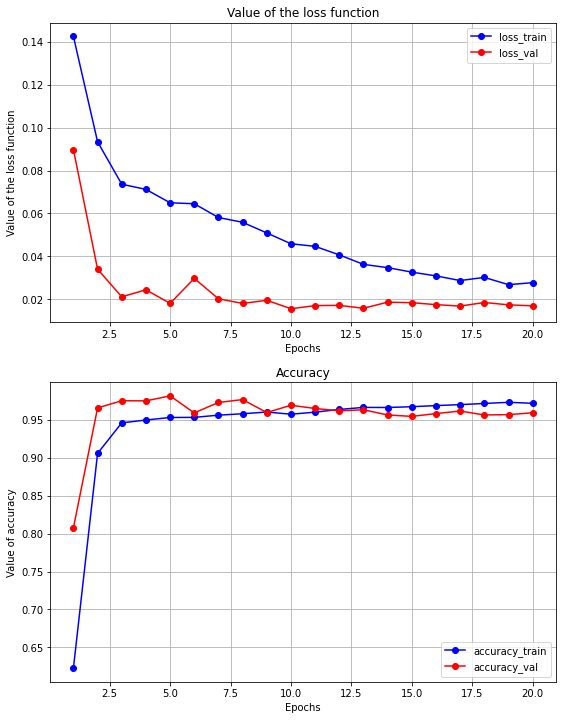

In [68]:
import matplotlib.pyplot as plt
print("----- Efficient Net -----")
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
plt.tight_layout(pad=2)
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
loss = history_B6.history['loss']
loss_val = history_B6.history['val_loss']
epochs = range(1, len(loss)+1)
axs[0].plot(epochs, loss, '-bo', label='loss_train')
axs[0].plot(epochs, loss_val, '-ro', label='loss_val')
axs[0].set_title('Value of the loss function')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Value of the loss function')
axs[0].legend()
axs[0].grid()
acc = history_B6.history['binary_accuracy']
acc_val = history_B6.history['val_binary_accuracy']
axs[1].plot(epochs, acc, '-bo', label='accuracy_train')
axs[1].plot(epochs, acc_val, '-ro', label='accuracy_val')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Value of accuracy')
axs[1].legend()
axs[1].grid()
plt.show()



In [69]:
test = tf.data.TFRecordDataset(TEST_FILENAMES, num_parallel_reads=AUTO)
mappedTest = test.map(read_labeled_tfrecord)
print(mappedTest)
labels = []
for ele in mappedTest:
    labels.append(ele[1].numpy())    
#     break
# labels

Tensor("ParseSingleExample/ParseExample/ParseExampleV2:1", shape=(), dtype=int64)
label Tensor("Cast_1:0", shape=(), dtype=float32)
<MapDataset shapes: ((128, 128, 3), ()), types: (tf.float32, tf.float32)>


In [70]:

test_ds = get_test_dataset(True)
print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)

probabilities7 = model_B6.predict(test_images_ds, verbose=1)


Tensor("ParseSingleExample/ParseExample/ParseExampleV2:1", shape=(), dtype=int64)
label Tensor("Cast_1:0", shape=(), dtype=float32)
Computing predictions...
69/69 [==============================] - 17s 89ms/step


In [71]:
max(probabilities7)

array([0.8865131], dtype=float32)

In [72]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(y_true, y_pred):
    transdict = {1: "malignant", 0: "benign"}
    y_t = np.array([transdict[x] for x in y_true])
    y_p = np.array([transdict[x] for x in y_pred])
    
    labels = ["benign", "malignant"]
    index_labels = ["actual benign", "actual malignant"]
    col_labels = ["predicted benign", "predicted malignant"]
    confusion = confusion_matrix(y_t, y_p, labels=labels)
    confusion_df = pd.DataFrame(confusion, index=index_labels, columns=col_labels)
    for n in range(2):
        confusion_df.iloc[n] = confusion_df.iloc[n] / confusion_df.sum(axis=1).iloc[n]
    return confusion_df

----- Efficient Net -----
Best Threshold=0.234099, G-Mean=0.798


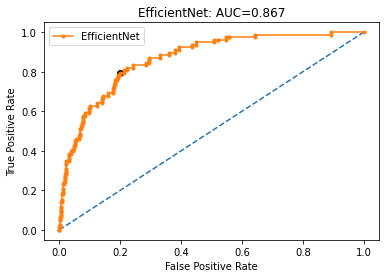

[[3428  848]
 [  16   62]]


Text(0.5, 1.0, 'Confusion Matrix - EfficientNet')

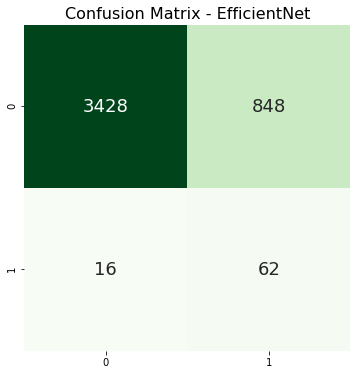

In [73]:
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix, auc, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
print("----- Efficient Net -----")
precision, recall, thresholds = precision_recall_curve(labels, probabilities7)
fpr, tpr, thresholds = roc_curve(labels, probabilities7)
ns_auc = roc_auc_score(labels, probabilities7)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--')#, label='No Model')
pyplot.plot(fpr, tpr, marker='.', label='EfficientNet')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black')#, label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.title('EfficientNet: AUC=%.3f' % (ns_auc))
# show the plot
pyplot.show()

predictionsEN = np.where(probabilities7 >= thresholds[ix], 1, 0)
confusion = confusion_matrix(labels,predictionsEN )
print(confusion)
plt.figure(figsize=(6,6))
sns.heatmap(confusion, cbar=False, annot=True, fmt="g", annot_kws={'size':18}, square=True, cmap="Greens")
plt.title('Confusion Matrix - EfficientNet', size=16)




In [74]:
##flattening the list to use in the confusion matrix percentages##

h =(predictionsEN.tolist())

def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:            
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

k = flatten_list(h)

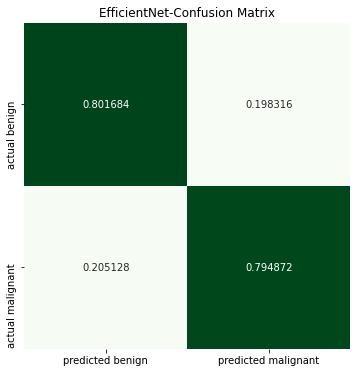

In [75]:
confusion = get_confusion_matrix(labels,k)
plt.figure(figsize=(6,6))
plt.title('EfficientNet-Confusion Matrix')
sns.heatmap(confusion, cbar=False, annot=True, fmt="g", square=True, cmap="Greens");

In [76]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

print(classification_report(labels, predictionsEN))

              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89      4276
         1.0       0.07      0.79      0.13        78

    accuracy                           0.80      4354
   macro avg       0.53      0.80      0.51      4354
weighted avg       0.98      0.80      0.87      4354



In [77]:
test_2 = get_test_dataset(True)
test_3 = get_test_dataset(False)

test_ids_ds = test_3.map(lambda image, image_name: image_name).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch


Tensor("ParseSingleExample/ParseExample/ParseExampleV2:1", shape=(), dtype=int64)
label Tensor("Cast_1:0", shape=(), dtype=float32)


In [78]:

pred_df7 = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities7)})

pred_df7.head()

,image_name,target
0,ISIC_0076262,0.075777
1,ISIC_0074268,0.005633
2,ISIC_0082543,0.023477
3,ISIC_0075663,0.111640
4,ISIC_0089401,0.016985


In [79]:
#ISIC_0178235 checks

print(meta_df_7.loc[meta_df_7['image_name'] == 'ISIC_0076742'])
print(pred_df7.loc[pred_df7['image_name'] == 'ISIC_0076742'])

      image_name    target
11  ISIC_0076742  0.108736
     image_name    target
5  ISIC_0076742  0.118694


# Ensemble Section

In [80]:
#checks
test_chk = pd.merge(meta_df_7, pred_df7, on='image_name')
print(meta_df_7.dtypes)
print(pred_df7.dtypes)
print(test_chk)
                            
                          
                          

image_name     object
target        float32
dtype: object
image_name     object
target        float32
dtype: object
        image_name  target_x  target_y
0     ISIC_0074268  0.010681  0.005633
1     ISIC_0075663  0.307374  0.111640
2     ISIC_0076262  0.025987  0.075777
3     ISIC_0076742  0.108736  0.118694
4     ISIC_0082543  0.018413  0.023477
...            ...       ...       ...
4349  ISIC_9997614  0.323928  0.080989
4350  ISIC_9998582  0.039471  0.102854
4351  ISIC_9998937  0.185668  0.105101
4352  ISIC_9999320  0.020293  0.001228
4353  ISIC_9999666  0.181792  0.130022

[4354 rows x 3 columns]


In [81]:
ensemble1 = (test_chk['target_x']* 0.4 + test_chk['target_y']*0.6)
ensemble_img1 = test_chk['image_name']
ensemble_sub1 = pd.concat([ensemble_img1, ensemble1], axis = 1)
ensemble_sub1.columns = ['image_name', 'probability']
ensemble_sub1.head()

,image_name,probability
0,ISIC_0074268,0.007652
1,ISIC_0075663,0.189934
2,ISIC_0076262,0.055861
3,ISIC_0076742,0.114711
4,ISIC_0082543,0.021452


Best Threshold=0.272109, G-Mean=0.813


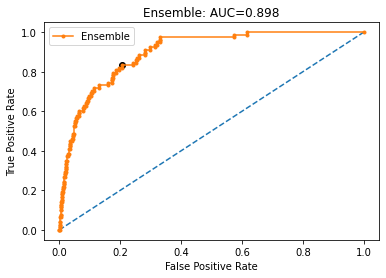

In [82]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from numpy import argmax
from numpy import sqrt
from numpy import arange
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

precision, recall, thresholds = precision_recall_curve(testy['target'], ensemble_sub1['probability'])
fpr, tpr, thresholds = roc_curve(testy['target'], ensemble_sub1['probability'])
ns_auc = roc_auc_score(testy['target'], ensemble_sub1['probability'])
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--')#, label='No Model')
pyplot.plot(fpr, tpr, marker='.', label='Ensemble')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black')#, label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.title('Ensemble: AUC=%.3f' % (ns_auc))
# show the plot
pyplot.show()

              precision    recall  f1-score   support

           0       1.00      0.79      0.88      4276
           1       0.07      0.83      0.13        78

    accuracy                           0.79      4354
   macro avg       0.53      0.81      0.50      4354
weighted avg       0.98      0.79      0.87      4354

[[3391  885]
 [  13   65]]


Text(0.5, 1.0, 'Confusion Matrix - Ensemble')

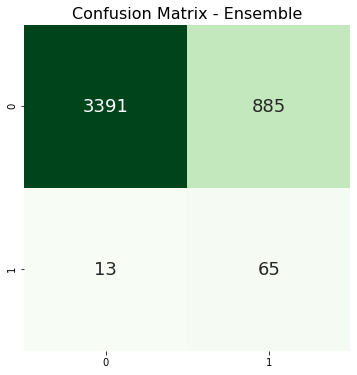

In [83]:
from sklearn.metrics import classification_report
predictionsEN_Fin = np.where(ensemble_sub1['probability'] >= thresholds[ix], 1, 0)
print(classification_report(testy['target'], predictionsEN_Fin))
confusion = confusion_matrix(testy['target'],predictionsEN_Fin )
print(confusion)
plt.figure(figsize=(6,6))
sns.heatmap(confusion, cbar=False, annot=True, fmt="g", annot_kws={'size':18}, square=True, cmap="Greens")
plt.title('Confusion Matrix - Ensemble', size=16)

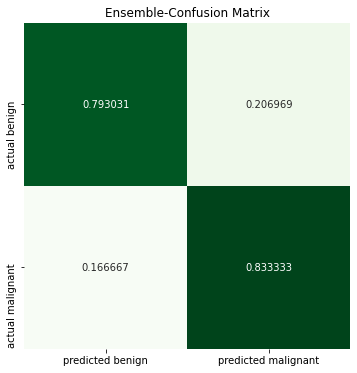

In [84]:
confusion = get_confusion_matrix(testy['target'],predictionsEN_Fin)
plt.figure(figsize=(6,6))
plt.title('Ensemble-Confusion Matrix')
sns.heatmap(confusion, cbar=False, annot=True, fmt="g", square=True, cmap="Greens");